In [ ]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn as sk
import shapefile as shp
import pandas as pd
import math
#from mpl_toolkits.basemap import Basemap

In [2]:
sf = shp.Reader("NFDB_point/NFDB_point_20160923")
shapes = sf.shapes()

In [3]:
records = sf.records()
fireArr = []
shapeRecs = sf.iterShapeRecords()
for x in shapeRecs:
    fireArr.append(x.record[0:])

In [4]:
df = pd.DataFrame(fireArr, columns=['src_agency', 'fire_id', 'firename','latitude','longitude','year','month','day','rep_date','attk_date','out_date','decade','size_ha','cause','protzone','fire_type','more_info','cfs_ref_id','cfs_note','cfs_note2','acq_date','ag_srcfile'])

In [5]:
df = df[(df["cause"] == "L")]

In [2]:
#62.421221
#-119.981689
alberta_area = df[(df["latitude"] < 62.421221) & (df["longitude"] > -119.981689) & (df["latitude"] > 59.142487) & (df["longitude"] < -106.754150)]

NameError: name 'df' is not defined

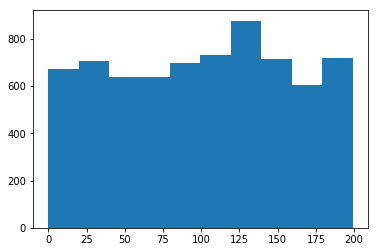

In [7]:
from sklearn.cluster import KMeans
num_clusters = 200
kmeans = KMeans(n_clusters=num_clusters)

kcluster = kmeans.fit_predict(alberta_area[['longitude','latitude']])

plt.figure()
plt.hist(kcluster)
plt.show()

In [8]:
allFiresX = alberta_area["latitude"].as_matrix()
allFiresY = alberta_area["longitude"].as_matrix()

In [ ]:
new_array = []
for i in range(allFiresY.size):
    new_array.append([allFiresX[i], allFiresY[i]])
new_array = np.array(new_array)

In [ ]:
#https://pythonprogramming.net/mean-shift-from-scratch-python-machine-learning-tutorial/
from matplotlib import style
style.use('ggplot')

##plt.scatter(X[:,0], X[:,1], s=150)
##plt.show()

colors = 10*["g","r","c","b","k"]

class Mean_Shift:
    def __init__(self, radius=4):
        self.radius = radius

    def fit(self, data):
        centroids = {}

        for i in range(len(data)):
            centroids[i] = data[i]
        
        while True:
            new_centroids = []
            for i in centroids:
                in_bandwidth = []
                centroid = centroids[i]
                for featureset in data:
                    if np.linalg.norm(featureset-centroid) < self.radius:
                        in_bandwidth.append(featureset)

                new_centroid = np.average(in_bandwidth,axis=0)
                new_centroids.append(tuple(new_centroid))

            uniques = sorted(list(set(new_centroids)))

            prev_centroids = list(dict(centroids))

            centroids = {}
            for i in range(len(uniques)):
                centroids[i] = np.array(uniques[i])

            optimized = True

            for i in centroids:
                if not np.array_equal(centroids[i], prev_centroids[i]):
                    optimized = False
                if not optimized:
                    break
                
            if optimized:
                break

        self.centroids = centroids



clf = Mean_Shift()
clf.fit(new_array)

centroids = clf.centroids

plt.scatter(new_array[:,0], new_array[:,1], s=5)

for c in centroids:
    plt.scatter(centroids[c][0], centroids[c][1], color='k', marker='*', s=1)
plt.show()

In [18]:
for c in centroids:
    print(centroids[c][0], centroids[c][1])

60.1038253288 -116.259883494
60.1039583592 -116.261509298
60.1042382 -116.260668095
60.1582357672 -114.92696854
60.1583646405 -114.9244523
60.1584865522 -114.925291686
60.1587879065 -115.072395365
60.1589006317 -114.921137623
60.1589346757 -115.071555901
60.1589766006 -114.917799935


In [ ]:
# clustering.py contains classes and functions that cluster data points
import sys, math, random
# -- The Point class represents points in n-dimensional space
class Point:
    # Instance variables
    # self.coords is a list of coordinates for this Point
    # self.n is the number of dimensions this Point lives in (ie, its space)
    # self.reference is an object bound to this Point
    # Initialize new Points
    def __init__(self, coords, reference=None):
        self.coords = coords
        self.n = len(coords)
        self.reference = reference
    # Return a string representation of this Point
    def __repr__(self):
        return str(self.coords)
# -- The Cluster class represents clusters of points in n-dimensional space
class Cluster:
    # Instance variables
    # self.points is a list of Points associated with this Cluster
    # self.n is the number of dimensions this Cluster's Points live in
    # self.centroid is the sample mean Point of this Cluster
    # Initialize new Clusters
    def __init__(self, points):
        # We forbid empty Clusters (they don't make mathematical sense!)
        if len(points) == 0: raise Exception("ILLEGAL: EMPTY CLUSTER")
        self.points = points
        self.n = points[0].n
        # We also forbid Clusters containing Points in different spaces
        # Ie, no Clusters with 2D Points and 3D Points
        for p in points:
            if p.n != self.n: raise Exception("ILLEGAL: MULTISPACE CLUSTER")
        # Figure out what the centroid of this Cluster should be
        self.centroid = self.calculateCentroid()
    # Return a string representation of this Cluster
    def __repr__(self):
        return str(self.points)
    # Update function for the K-means algorithm
    # Assigns a new list of Points to this Cluster, returns centroid difference
    def update(self, points):
        old_centroid = self.centroid
        self.points = points
        self.centroid = self.calculateCentroid()
        return getDistance(old_centroid, self.centroid)
    # Calculates the centroid Point - the centroid is the sample mean Point
    # (in plain English, the average of all the Points in the Cluster)
    def calculateCentroid(self):
        centroid_coords = []
        # For each coordinate:
        for i in range(self.n):
            # Take the average across all Points
            centroid_coords.append(0.0)
            for p in self.points:
                centroid_coords[i] = centroid_coords[i]+p.coords[i]
            centroid_coords[i] = centroid_coords[i]/len(self.points)
        # Return a Point object using the average coordinates
        return Point(centroid_coords)
    # Return the single-linkage distance between this and another Cluster
    def getSingleDistance(self, cluster):
        ret = getDistance(self.points[0], cluster.points[0])
        for p in self.points:
            for q in cluster.points:
                distance = getDistance(p, q)
                if distance < ret: ret = distance
        return ret
    # Return the complete-linkage distance between this and another Cluster
    def getCompleteDistance(self, cluster):
        ret = getDistance(self.points[0], cluster.points[0])
        for p in self.points:
            for q in cluster.points:
                distance = getDistance(p, q)
                if distance > ret: ret = distance
        return ret
    # Return the centroid-linkage distance between this and another Cluster
    def getCentroidDistance(self, cluster):
        return getDistance(self.centroid, cluster.centroid)
    # Return the fusion of this and another Cluster
    def fuse(self, cluster):
        # Forbid fusion of Clusters in different spaces
        if self.n != cluster.n: raise Exception("ILLEGAL FUSION")
        points = self.points
        points.extend(cluster.points)
        return Cluster(points)
# -- Return Clusters of Points formed by K-means clustering
def kmeans(points, k, cutoff):
    # Randomly sample k Points from the points list, build Clusters around them
    initial = random.sample(points, k)
    clusters = []
    for p in initial: clusters.append(Cluster([p]))
    # Enter the program loop
    while True:
        # Make a list for each Cluster
        lists = []
        for c in clusters: lists.append([])
        # For each Point:
        for p in points:
            # Figure out which Cluster's centroid is the nearest
            smallest_distance = getDistance(p, clusters[0].centroid)
            index = 0
            for i in range(len(clusters[1:])):
                distance = getDistance(p, clusters[i+1].centroid)
                if distance < smallest_distance:
                    smallest_distance = distance
                    index = i+1
            # Add this Point to that Cluster's corresponding list
            lists[index].append(p)
        # Update each Cluster with the corresponding list
        # Record the biggest centroid shift for any Cluster
        biggest_shift = 0.0
        for i in range(len(clusters)):
            shift = clusters[i].update(lists[i])
            biggest_shift = max(biggest_shift, shift)
        # If the biggest centroid shift is less than the cutoff, stop
        if biggest_shift < cutoff: break
    # Return the list of Clusters
    return clusters
# -- Return a distance matrix which captures distances between all Clusters
def makeDistanceMatrix(clusters, linkage):
    ret = dict()
    for i in range(len(clusters)):
        for j in range(len(clusters)):
            if j == i: break
            if linkage == 's':
                ret[(i,j)] = clusters[i].getSingleDistance(clusters[j])
            elif linkage == 'c':
                ret[(i,j)] = clusters[i].getCompleteDistance(clusters[j])
            elif linkage == 't':
                ret[(i,j)] = clusters[i].getCentroidDistance(clusters[j])
            else: raise Exception("INVALID LINKAGE")
    return ret
# -- Return Clusters of Points formed by agglomerative clustering
def agglo(points, linkage, cutoff):
    # Currently, we only allow single, complete, or average linkage
    if not linkage in [ 's', 'c', 't' ]: raise Exception("INVALID LINKAGE")
    # Create singleton Clusters, one for each Point
    clusters = []
    for p in points: clusters.append(Cluster([p]))
    # Set the min_distance between Clusters to zero
    min_distance = 0
    # Loop until the break statement is made
    while (True):
        # Compute a distance matrix for all Clusters
        distances = makeDistanceMatrix(clusters, linkage)
        # Find the key for the Clusters which are closest together
        min_key = list(distances.keys())[0]
        min_distance = distances[min_key]
        for key in distances.keys():
            if distances[key] < min_distance:
                min_key = key
                min_distance = distances[key]
        # If the min_distance is bigger than the cutoff, terminate the loop
        # Otherwise, agglomerate the closest clusters
        if min_distance > cutoff or len(clusters) == 1: break
        else:
            c1, c2 = clusters[min_key[0]], clusters[min_key[1]]
            clusters.remove(c1)
            clusters.remove(c2)
            clusters.append(c1.fuse(c2))
    # Return the list of Clusters
    return clusters
# -- Get the Euclidean distance between two Points
def getDistance(a, b):
    # Forbid measurements between Points in different spaces
    if a.n != b.n: raise Exception("ILLEGAL: NON-COMPARABLE POINTS")
    # Euclidean distance between a and b is sqrt(sum((a[i]-b[i])^2) for all i)
    ret = 0.0
    for i in range(a.n):
        ret = ret+pow((a.coords[i]-b.coords[i]), 2)
    return math.sqrt(ret)
# -- Create a random Point in n-dimensional space
def makeRandomPoint(n, lower, upper):
    coords = []
    for i in range(n): coords.append(random.uniform(lower, upper))
    return Point(coords)
# -- Plot Clusters using Tkinter
def plot(clusters):
    root = Tk()
    cp = ClusterPlot(root)
    root.mainLoop()
# -- Main function

In [ ]:
def main(args):
    num_points, n, lower, upper = 10, 2, -200, 200
    #k, kmeans_cutoff = 3, 0.5
    linkage, agglo_cutoff = 's', 0.3
    # Create num_points random Points in n-dimensional space, print them
    #print("\nPOINTS:")
    points = []
    for i in range(allFiresX.size):
        p = Point([allFiresX[i], allFiresY[i]])
        points.append(p)
    print ("yep")
    # Cluster the points using the K-means algorithm, print the results
    #clusters = kmeans(points, k, kmeans_cutoff)
    #print("\nK-MEANS\nCLUSTERS:")
    #for c in clusters: print("C:", c)
    # Cluster the points using the agglomerative algorithm, print the results
    clusters = agglo(points, linkage, agglo_cutoff)
    print("\nAGGLOMERATIVE\nCLUSTERS:")
    for c in clusters: print("C:", c)
# -- The following code executes upon command-line invocation
if __name__ == "__main__": main(sys.argv)

In [ ]:
allFiresX